In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 8s - loss: 0.0240

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 5s 556ms/step - loss: 0.0160
Average validation loss: 0.6419962644577026
4/4 [==============================] - 5s 568ms/step - loss: 0.0160 - val_loss: 0.6420
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 7s 546ms/step - loss: 0.0099 - val_loss: 0.6420
Average validation loss: 0.5430952906608582
4/4 [==============================] - 7s 559ms/step - loss: 0.0099 - val_loss: 0.5925
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 9s 540ms/step - loss: 0.0071 - val_loss: 0.5925
Average validation loss: 0.5087599158287048
4/4 [==============================] - 9s 551ms/step - loss: 0.0071 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 7s 858ms/step - loss: 5.6046e-07
Average validation loss: 0.00015870090282987803
8/8 [==============================] - 7s 871ms/step - loss: 5.6046e-07 - val_loss: 1.5870e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 14s 898ms/step - loss: 5.4796e-07 - val_loss: 1.5870e-04
Average validation loss: 0.00039900797128211707
8/8 [==============================] - 14s 912ms/step - loss: 5.4796e-07 - val_loss: 2.7885e-04
Epoch 3/10
8/8 [==============================] - 22s 901ms/step - loss: 5.3882e-07 - val_loss: 2.7885e-04
Average validation loss: 0.0032461697701364756
8/8 [==============================] - 22s 918ms/step - loss: 5.3882e-07 - val_loss: 0.0013    
Epoch 4/10
8/8 [==============================] - 29s 878ms/step - loss: 5.2794e-07 - val_loss: 0.0013
Avera

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 757ms/step - loss: 2.5835e-06
Average validation loss: 0.1364469967838886
12/12 [==============================] - 9s 768ms/step - loss: 2.5835e-06 - val_loss: 0.1364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 741ms/step - loss: 2.8368e-06 - val_loss: 0.1364
Average validation loss: 0.0770060808378427
12/12 [==============================] - 18s 752ms/step - loss: 2.8368e-06 - val_loss: 0.1067
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 28s 773ms/step - loss: 2.7697e-06 - val_loss: 0.1067
Average validation loss: 0.050157045324643455
12/12 [==============================] - 28

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 739ms/step - loss: 2.3821e-06
Average validation loss: 0.05590384500101209
16/16 [==============================] - 12s 748ms/step - loss: 2.3821e-06 - val_loss: 0.0559
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 742ms/step - loss: 2.3491e-06 - val_loss: 0.0559
Average validation loss: 0.07705764297861606
16/16 [==============================] - 24s 753ms/step - loss: 2.3491e-06 - val_loss: 0.0665
Epoch 3/10
16/16 [==============================] - 36s 735ms/step - loss: 2.3112e-06 - val_loss: 0.0665
Average validation loss: 0.042525338707491755
16/16 [==============================] - 36s 746ms/step - loss: 2.3112e-06 - val_loss: 0.0585
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/wei

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 698ms/step - loss: 6.0416e-07
Average validation loss: 0.04167874064296484
20/20 [==============================] - 14s 707ms/step - loss: 6.0416e-07 - val_loss: 0.0417
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 686ms/step - loss: 5.6470e-07 - val_loss: 0.0417
Average validation loss: 0.03632836202159524
20/20 [==============================] - 28s 696ms/step - loss: 5.6470e-07 - val_loss: 0.0390
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 42s 680ms/step - loss: 5.4969e-07 - val_loss: 0.0390
Average validation loss: 0.040238482877612114
20/20 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 16s 684ms/step - loss: 1.0758e-06
Average validation loss: 0.06801847430566947
24/24 [==============================] - 17s 693ms/step - loss: 1.0758e-06 - val_loss: 0.0680
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 33s 680ms/step - loss: 8.6980e-07 - val_loss: 0.0680
Average validation loss: 0.0768069972594579
24/24 [==============================] - 33s 689ms/step - loss: 8.6980e-07 - val_loss: 0.0724
Epoch 3/10
24/24 [==============================] - 50s 681ms/step - loss: 7.8334e-07 - val_loss: 0.0724
Average validation loss: 0.05641961718599001
24/24 [==============================] - 50s 691ms/step - loss: 7.8334e-07 - val_loss: 0.0671
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weigh

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 675ms/step - loss: 2.0826e-06
Average validation loss: 0.07644554525613785
40/40 [==============================] - 27s 685ms/step - loss: 2.0826e-06 - val_loss: 0.0764
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 54s 673ms/step - loss: 1.8466e-06 - val_loss: 0.0764
Average validation loss: 0.11978752426803112
40/40 [==============================] - 55s 682ms/step - loss: 1.8466e-06 - val_loss: 0.0981
Epoch 3/10
40/40 [==============================] - 82s 684ms/step - loss: 1.7131e-06 - val_loss: 0.0981
Average validation loss: 0.0636604230850935
40/40 [==============================] - 82s 693ms/step - loss: 1.7131e-06 - val_loss: 0.0866
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weigh

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 696ms/step - loss: 1.5539e-06
Average validation loss: 0.05519444055001562
48/48 [==============================] - 34s 706ms/step - loss: 1.5539e-06 - val_loss: 0.0552
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 694ms/step - loss: 1.0933e-06 - val_loss: 0.0552
Average validation loss: 0.05546328939575081
48/48 [==============================] - 68s 704ms/step - loss: 1.0933e-06 - val_loss: 0.0553
Epoch 3/10
48/48 [==============================] - 101s 699ms/step - loss: 8.8212e-07 - val_loss: 0.0553
Average validation loss: 0.030992560360270243
48/48 [==============================] - 102s 709ms/step - loss: 8.8212e-07 - val_loss: 0.0472
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/w

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 39s 695ms/step - loss: 1.3759e-06
Average validation loss: 0.05227623713601913
56/56 [==============================] - 40s 705ms/step - loss: 1.3759e-06 - val_loss: 0.0523
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 79s 695ms/step - loss: 9.4290e-07 - val_loss: 0.0523
Average validation loss: 0.05809542954167617
56/56 [==============================] - 79s 705ms/step - loss: 9.4290e-07 - val_loss: 0.0552
Epoch 3/10
56/56 [==============================] - 118s 703ms/step - loss: 7.2685e-07 - val_loss: 0.0552
Average validation loss: 0.051832932978868484
56/56 [==============================] - 119s 713ms/step - loss: 7.2685e-07 - val_loss: 0.0541
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/w

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 44s 690ms/step - loss: 7.6848e-07
Average validation loss: 0.04178287147078663
64/64 [==============================] - 45s 701ms/step - loss: 7.6848e-07 - val_loss: 0.0418
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 89s 692ms/step - loss: 5.2854e-07 - val_loss: 0.0418
Average validation loss: 0.030642026744317263
64/64 [==============================] - 90s 703ms/step - loss: 5.2854e-07 - val_loss: 0.0362
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 134s 684ms/step - loss: 4.0858e-07 - val_loss: 0.0362
Average validation loss: 0.02865765073511284
64/64 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 692ms/step - loss: 5.7599e-07
Average validation loss: 0.06407801217089097
72/72 [==============================] - 51s 702ms/step - loss: 5.7599e-07 - val_loss: 0.0641
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 701ms/step - loss: 3.9195e-07 - val_loss: 0.0641
Average validation loss: 0.041944533948683076
72/72 [==============================] - 102s 711ms/step - loss: 3.9195e-07 - val_loss: 0.0530
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 152s 697ms/step - loss: 2.9855e-07 - val_loss: 0.0530
Average validation loss: 0.033018780717005335
72/72 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 698ms/step - loss: 6.2417e-07
Average validation loss: 0.028923677746206522
80/80 [==============================] - 57s 708ms/step - loss: 6.2417e-07 - val_loss: 0.0289
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 714ms/step - loss: 4.3948e-07 - val_loss: 0.0289
Average validation loss: 0.04304862404242158
80/80 [==============================] - 115s 723ms/step - loss: 4.3948e-07 - val_loss: 0.0360
Epoch 3/10
80/80 [==============================] - 170s 697ms/step - loss: 3.3845e-07 - val_loss: 0.0360
Average validation loss: 0.039614086225628856
80/80 [==============================] - 171s 706ms/step - loss: 3.3845e-07 - val_loss: 0.0372
Epoch 4/10
80/80 [==============================] - 227s 696ms/step - loss: 2.8310e-07 - val_loss: 0.0372
Average v

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 67s 701ms/step - loss: 1.5893e-06
Average validation loss: 0.05596450650288413
96/96 [==============================] - 68s 711ms/step - loss: 1.5893e-06 - val_loss: 0.0560
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 136s 701ms/step - loss: 1.0600e-06 - val_loss: 0.0560
Average validation loss: 0.049755835304191955
96/96 [==============================] - 137s 711ms/step - loss: 1.0600e-06 - val_loss: 0.0529
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 204s 700ms/step - loss: 7.7430e-07 - val_loss: 0.0529
Average validation loss: 0.05587410118217425
96/96 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 709ms/step - loss: 4.5986e-07
Average validation loss: 0.032314420118927954
120/120 [==============================] - 86s 719ms/step - loss: 4.5986e-07 - val_loss: 0.0323
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 170s 701ms/step - loss: 3.1692e-07 - val_loss: 0.0323
Average validation loss: 0.02150864015954236
120/120 [==============================] - 172s 711ms/step - loss: 3.1692e-07 - val_loss: 0.0269
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 707ms/step - loss: 2.5008e-07 - val_loss: 0.0269
Average validation loss: 0.03969407818512991
120/120 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 710ms/step - loss: 3.7330e-07
Average validation loss: 0.0500000384345185
144/144 [==============================] - 104s 720ms/step - loss: 3.7330e-07 - val_loss: 0.0500
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 205s 701ms/step - loss: 2.5545e-07 - val_loss: 0.0500
Average validation loss: 0.022885762012770608
144/144 [==============================] - 206s 711ms/step - loss: 2.5545e-07 - val_loss: 0.0364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 698ms/step - loss: 2.1263e-07 - val_loss: 0.0364
Average validation loss: 0.2368298607567946
144/144 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 114s 713ms/step - loss: 8.1390e-07
Average validation loss: 0.035985737515147775
160/160 [==============================] - 116s 723ms/step - loss: 8.1390e-07 - val_loss: 0.0360
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 229s 706ms/step - loss: 5.4145e-07 - val_loss: 0.0360
Average validation loss: 0.04284649222681765
160/160 [==============================] - 230s 716ms/step - loss: 5.4145e-07 - val_loss: 0.0394
Epoch 3/10
160/160 [==============================] - 344s 709ms/step - loss: 4.2966e-07 - val_loss: 0.0394
Average validation loss: 0.060549955554597544
160/160 [==============================] - 345s 719ms/step - loss: 4.2966e-07 - val_loss: 0.0465
Epoch 4/10
160/160 [==============================] - 458s 706ms/step - loss: 3.9131e-07 - val_loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 142s 709ms/step - loss: 1.3936e-06
Average validation loss: 0.06292305357055739
200/200 [==============================] - 144s 719ms/step - loss: 1.3936e-06 - val_loss: 0.0629
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 284s 701ms/step - loss: 9.3442e-07 - val_loss: 0.0629
Average validation loss: 0.04820766376098618
200/200 [==============================] - 286s 711ms/step - loss: 9.3442e-07 - val_loss: 0.0556
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 428s 708ms/step - loss: 7.0066e-07 - val_loss: 0.0556
Average validation loss: 0.05599375048419461
200/200 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:30 - loss: 1.9601e-07

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 705ms/step - loss: 3.9418e-07
Average validation loss: 0.024094946950208397
240/240 [==============================] - 172s 716ms/step - loss: 3.9418e-07 - val_loss: 0.0241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 341s 703ms/step - loss: 2.6855e-07 - val_loss: 0.0241
Average validation loss: 0.04333291445509531
240/240 [==============================] - 343s 713ms/step - loss: 2.6855e-07 - val_loss: 0.0337
Epoch 3/10
240/240 [==============================] - 513s 708ms/step - loss: 2.1745e-07 - val_loss: 0.0337
Average validation loss: 0.05389854422731635
240/240 [==============================] - 515s 718ms/step - loss: 2.1745e-07 - val_loss: 0.0404
Epoch 4/10
240/240 [==============================] - 685s 707ms/step - loss: 1.8250e-07 - val_loss: 0

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13283792183760398, 0.08679859040672454, 0.09091942560682278, 0.07159592036045524, 0.06231814531981944, 0.06283832063743222, 0.05645392649341375, 0.04900980435234184, 0.04437899927982861, 0.03806190106020949, 0.033877804320590156, 0.03163829878228717, 0.04037342804838166, 0.04182221519748903, 0.0343648869288639, 0.03526515908219153, 0.03986153013964649, 0.03218872490326188]
std_val_losses =  [0.19928081746464466, 0.0730448623742994, 0.05359491323404781, 0.0343664305555809, 0.023609067088809818, 0.031708568079077154, 0.017529044876055347, 0.014268434797130431, 0.014662246979266179, 0.01498373893966823, 0.013481484145967696, 0.01055822881202121, 0.01979452174123248, 0.027836930904177614, 0.03301128060494063, 0.011603132130055368, 0.016961859154492498, 0.012472409373858613]


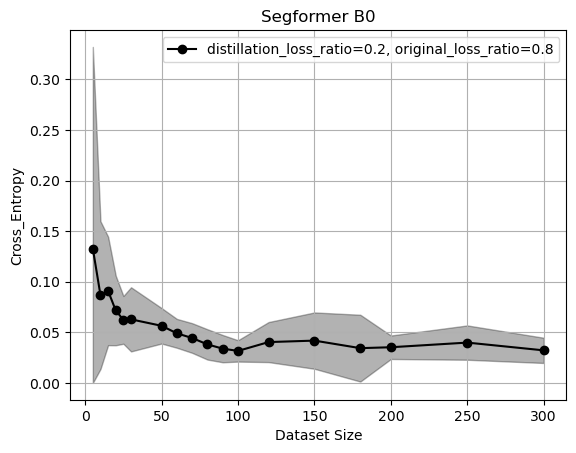

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()